# Cars dimensions

In [19]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
%matplotlib inline

In [2]:
# Loading dataset
df = pd.read_csv("CQA_Premium.csv")
sizes = df[['model_length_mm', 'model_width_mm']].dropna(0, 'any')
print("shape:", sizes.shape)

shape: (54808, 2)


## Primary plot

Here we plot dots with cars length as abcissas and cars width as ordinates. Then we arbitrarily select a default validation zone, along with two 'grey zones' within the default zone, where there are no dots.

In [28]:
# Plotting unique pairs of (length, width)
def rect_range(rangex, rangey):
    """ Creates a list of abcissas and ordinates,
        to plot a rectangle.
    """
    minx, maxx = rangex
    miny, maxy = rangey
    return [minx, maxx, maxx, minx, minx],\
           [miny, miny, maxy, maxy, miny]

def uniqueness(x, y):
    assert(len(x) == len(y))
    occurences = {}
    for pair in zip(x, y):
        if pair not in occurences.keys():
            occurences[pair] = 0
        occurences[pair] += 1
    pair_set = occurences.keys()
    return [p for p in pair_set if occurences[p] == 1],\
           [p for p in pair_set if occurences[p] > 1]
    
unique, non_unique = uniqueness(sizes['model_length_mm'][::10],
                                sizes['model_width_mm'][::10])

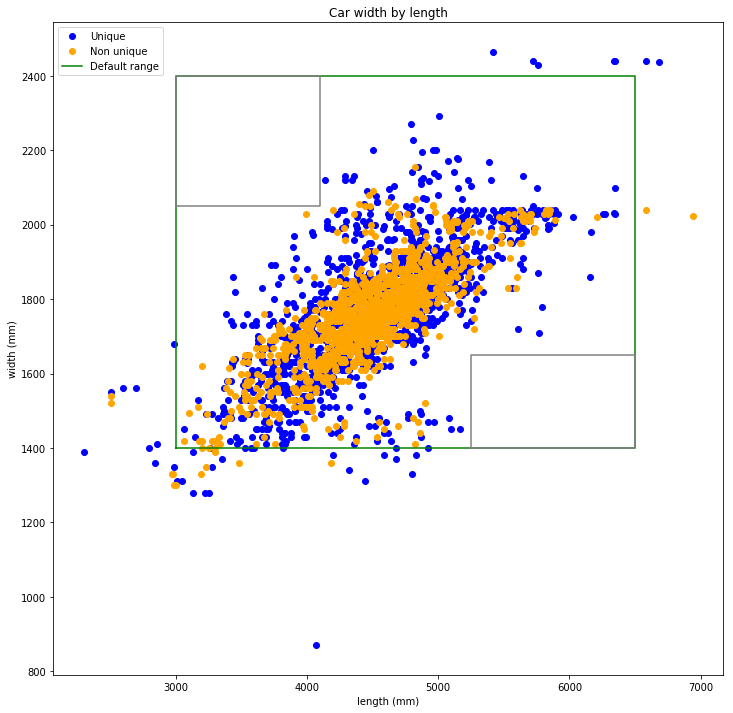

In [36]:
green_zone = rect_range((3000, 6500), (1400, 2400))
grey_zone_a = rect_range((3000, 4100), (2050, 2400))
grey_zone_b = rect_range((5250, 6500), (1400, 1650))

plt.figure(figsize=(12, 12))

plt.plot([p[0] for p in unique], [p[1] for p in unique],
         'o', label='Unique', c='blue')
plt.plot([p[0] for p in non_unique], [p[1] for p in non_unique],
         'o', label='Non unique', c='orange')
plt.plot(green_zone[0], green_zone[1],
         label='Default range', c='green')
plt.plot(grey_zone_a[0], grey_zone_a[1],
         c='grey')
plt.plot(grey_zone_b[0], grey_zone_b[1],
         c='grey')

plt.title("Car width by length")
plt.xlabel("length (mm)")
plt.ylabel("width (mm)")
plt.legend(loc='best')
plt.show()

## Anomaly generation

Here we generate wrong dots within the grey zone and outside the default zone.


In [45]:
def is_in(dot, zone):
    x, y = dot
    minx, maxx = zone[0][:2]
    miny, maxy = zone[1][1:3]
    if x < minx or x > maxx or y < miny or y > maxy:
        return False
    return True

def generate_dots(zone, n, deadzone=None):
    minx, maxx = zone[0][:2]
    miny, maxy = zone[1][1:3]
    dots = []
    while len(dots) < n:
        dot = rd.randint(minx, maxx), rd.randint(miny, maxy)
        if deadzone is None or not is_in(dot, deadzone):
            dots.append(dot)
    return dots

display_zone = rect_range((2000, 7000), (800, 2500))

wrong_dots = generate_dots(grey_zone_a, 100)\
            + generate_dots(grey_zone_b, 100)\
            + generate_dots(display_zone, 500, green_zone)

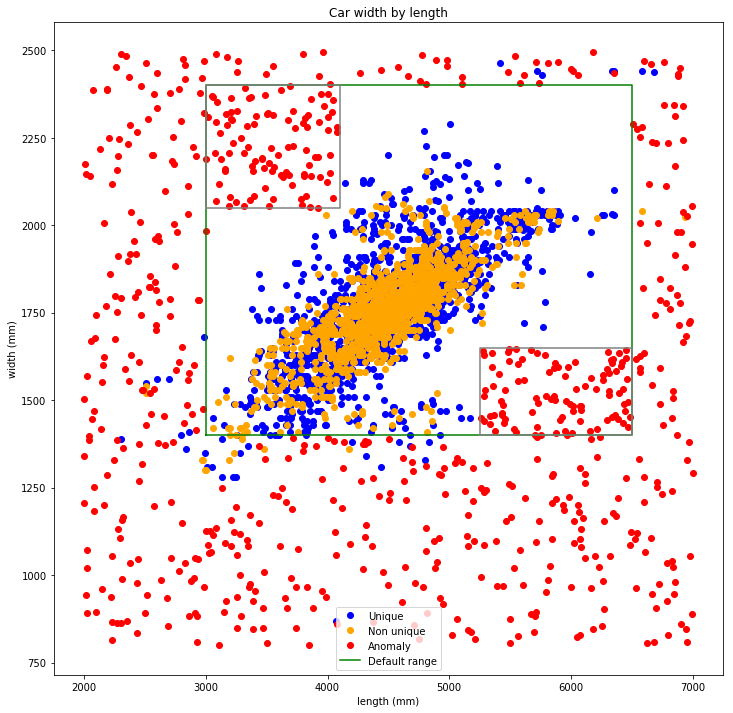

In [47]:
plt.figure(figsize=(12, 12))

plt.plot([p[0] for p in unique], [p[1] for p in unique],
         'o', label='Unique', c='blue')
plt.plot([p[0] for p in non_unique], [p[1] for p in non_unique],
         'o', label='Non unique', c='orange')
plt.plot([p[0] for p in wrong_dots], [p[1] for p in wrong_dots],
         'o', label='Anomaly', c='red')
plt.plot(green_zone[0], green_zone[1],
         label='Default range', c='green')
plt.plot(grey_zone_a[0], grey_zone_a[1],
         c='grey')
plt.plot(grey_zone_b[0], grey_zone_b[1],
         c='grey')

plt.title("Car width by length")
plt.xlabel("length (mm)")
plt.ylabel("width (mm)")
plt.legend(loc='best')
plt.show()

In [70]:
# Building new dataset
dataset = sizes.loc[::10]
dataset.insert(2, "anomaly", False)
to_append = pd.DataFrame([[dot[0], dot[1], True] for dot in wrong_dots], columns=dataset.columns)
dataset.append(to_append)
dataset

,model_length_mm,model_width_mm,anomaly
0,3720.0,1500.0,False
10,3920.0,1860.0,False
20,3560.0,1490.0,False
30,3480.0,1360.0,False
40,3490.0,1420.0,False
50,3480.0,1360.0,False
64,3530.0,1400.0,False
74,3700.0,1560.0,False
86,3600.0,1400.0,False
97,3240.0,1490.0,False
